If I don't prevent OpenMP threading, I end up with a *ton* of system time from multithreaded BLAS that actually lowers performance:

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import arviz as az
from emcee import EnsembleSampler
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import scipy.linalg as sl
import scipy.stats as ss
import starry
from starry import Map, System, Primary, Secondary
import starry_process
from starry_process import StarryProcess
import theano
import theano.tensor as tt
from theano.tensor.random.utils import RandomStream
from tqdm.notebook import tqdm
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [149]:
def _cho_solve(L, b):
    return tt.slinalg.solve_upper_triangular(L.T, tt.slinalg.solve_lower_triangular(L, b))

class LinearInterpolatedStarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm, num_maps):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm
        self._num_maps = num_maps

        self._mu = tt.concatenate([sp.mean_ylm]*num_maps)
        C = sp.cov_ylm
        self._Lambda = tt.zeros((num_maps*nlm, num_maps*nlm))
        for i in range(num_maps):
            start_idx = i*nlm
            end_idx = (i+1)*nlm
            self._Lambda = tt.set_subtensor(self._Lambda[start_idx:end_idx, start_idx:end_idx], C)

    @property
    def nt(self):
        return self._nt
    
    @property
    def nlm(self):
        return self._nlm
    
    @property
    def num_maps(self):
        return self._num_maps

    @property
    def sys(self):
        return self._sys
    
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    
    @property
    def a(self):
        return self._a
    
    @property
    def AInv_chol(self):
        return self._AInv_chol

    def _compute(self, t, flux, sigma_flux):
        num_maps = self.num_maps
        nt = self.nt
        nlm = self.nlm

        MM = self.sys.design_matrix(t)[:, :-1]  # We don't use any flux from the secondary, so [:, :-1]

        interval = nt // (num_maps-1)

        M = tt.zeros((nt, MM.shape[1] * num_maps))

        sections = [*(i * interval for i in range(0, num_maps - 1)), nt]
        for i, (lo, hi) in enumerate(pairwise(sections)):
            try:
                t_hi = t[hi]
            except IndexError:
                t_hi = t[-1]
            phi = (t[lo:hi] - t_hi) / (t[lo] - t_hi)
            n = phi.shape[0]
            coeffs = tt.zeros((n, num_maps))
            coeffs = tt.set_subtensor(coeffs[:, i], phi)
            coeffs = tt.set_subtensor(coeffs[:, i + 1], 1 - phi)
            M = tt.set_subtensor(M[lo:hi, :], tt.reshape(MM[lo:hi, None, :] * coeffs[:, :, None], (n, -1)))

        self._M = M
        
        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is
        # completely flat, so we set the first row and column of the precision
        # matrix to zero we do this manually here.  First we Cholesky decompose:
        #
        # Lambda[1:,1:] = L L^T
        #
        # Then, because of a quirk of theano (no gradients for `cho_solve!`,
        # WTF), we can compute Lambda[1:,1:]^{-1} via
        #
        # Lambda[1:,1:]^{-1} = tt.slinalg.solve_triangular(L.T, tt.slinalg.solve_triangular(L, tt.eye(nlm-1), lower=True), lower=False)
        #
        # encapsulated in our _cho_solve(...) function above

        # Also: the covariance matrix contains a "double-copy" of the starry
        # process covariance: CC = [[C, 0], [0, C]], and we only have to solve
        # one of them, and then can reconstruct the inverse as 
        # CC^{-1} = [[C^{-1}, 0], [0, C^{-1}]].
        logl = 0.

        for j in range(0, num_maps-1, 1):
            L1 = tt.slinalg.cholesky(Lambda[j*nlm+1:(j+1)*nlm,j*nlm+1:(j+1)*nlm])
            L2 = tt.slinalg.cholesky(Lambda[(j+1)*nlm+1:(j+2)*nlm,(j+1)*nlm+1:(j+2)*nlm])

            L = tt.slinalg.kron(tt.eye(2), L1) + tt.slinalg.kron(tt.eye(2, k=1), L2)

            Lambda_inv1 = _cho_solve(L1, tt.eye(nlm-1))
            Lambda_inv1 = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv1)

            Lambda_inv2 = _cho_solve(L2, tt.eye(nlm-1))
            Lambda_inv2 = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv2)

            Lambda_inv = tt.slinalg.kron(tt.eye(2), Lambda_inv1) + tt.slinalg.kron(tt.eye(2, k=1), Lambda_inv2)

            Mnew = M[:,(j)*nlm:(j+2)*nlm]

            sigma_flux2 = tt.square(sigma_flux)
            MTCinv = Mnew.T / sigma_flux2[None, :]
            MTCinvM = tt.dot(MTCinv, Mnew)

            AInv = Lambda_inv + MTCinvM

            AInv_chol = tt.slinalg.cholesky(AInv)
            
            a = _cho_solve(AInv_chol, tt.dot(Lambda_inv, mu[(j)*nlm:(j+2)*nlm]) + tt.dot(MTCinv, flux))

            b = tt.dot(Mnew, mu[(j)*nlm:(j+2)*nlm])
            r = flux - b

            Cinvr = r / sigma_flux2

            rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

            # Identity:
            # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
            # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
            # |B| = | A^-1 | |L[1:,1:]| |C|

            logdetB = tt.sum(tt.log(sigma_flux2)) + 2*tt.sum(tt.log(tt.diag(AInv_chol))) + 2*tt.sum(tt.log(tt.diag(L)))

            # (nt-2) because we have cancelled two dimensions due to the flat prior
            # on the [0,0] constant term in each of the interpolant maps.

            logl += -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-num_maps-1)*tt.log(2*np.pi)

        # print(logl.eval())

        self._a = a
        self._AInv_chol = AInv_chol
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = RandomStream(seed=np.random.randint(1<<32))

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + tt.slinalg.solve_upper_triangular(self.AInv_chol.T, rng.normal(size=(self.num_maps * nylm, size))).T

In [171]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0

prot = 30.0
porb = 4.887802443

stellar_inc = 90.0
stellar_obl = -30.0

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg, inc=stellar_inc, obl=stellar_obl),
              r=0.683, m=0.81, prot=prot, t0=0.0)
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=0.04*pri.r.eval(), m=1e-3*pri.m.eval(), prot=1.0,
                porb=porb, ecc=0.0, Omega=0, inc=90)
pri.map[1] = u1
pri.map[2] = u2

sys = System(pri, sec)

Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = prot / 20.0

num_maps = 2
nlm = 256

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

ys_true = np.zeros((num_maps, nlm))
for i in range(num_maps):
    ys_true[i, :] = sp.sample_ylm().eval()[0, :]
ys_true[0][0] = 1.
ys_true[1][0] = 1.02
# ys_true[2][0] = 1.03
# ys_true[3][0] = 1.04
# ys_true[4][0] = 1.01
# ys_true[5][0] = 0.9

T = 3*prot
t_in = np.arange(-T, T, dt_in_transit)
t_out = np.arange(-T, T, dt_out_transit)

t_in_transit = (t_in % sec.porb.eval() < Ttr_half) | (t_in % sec.porb.eval() > sec.porb.eval()-Ttr_half)
t_out_transit = (t_out % sec.porb.eval() < Ttr_half) | (t_out % sec.porb.eval() > sec.porb.eval()-Ttr_half)

t = np.sort(np.concatenate((
    t_in[t_in_transit],
    t_out[~t_out_transit],
)))
nt = len(t)

ssp = LinearInterpolatedStarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()), num_maps=num_maps)
ssp._compute(t, np.zeros_like(t), np.ones_like(t))

flux_true = ssp.design_matrix.eval() @ np.concatenate((ys_true))
sigma_flux = 1e-4*np.ones_like(flux_true)

flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [151]:
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval()

array(12339.00609929)

In [152]:
ssp.design_matrix.eval().shape

(1597, 512)

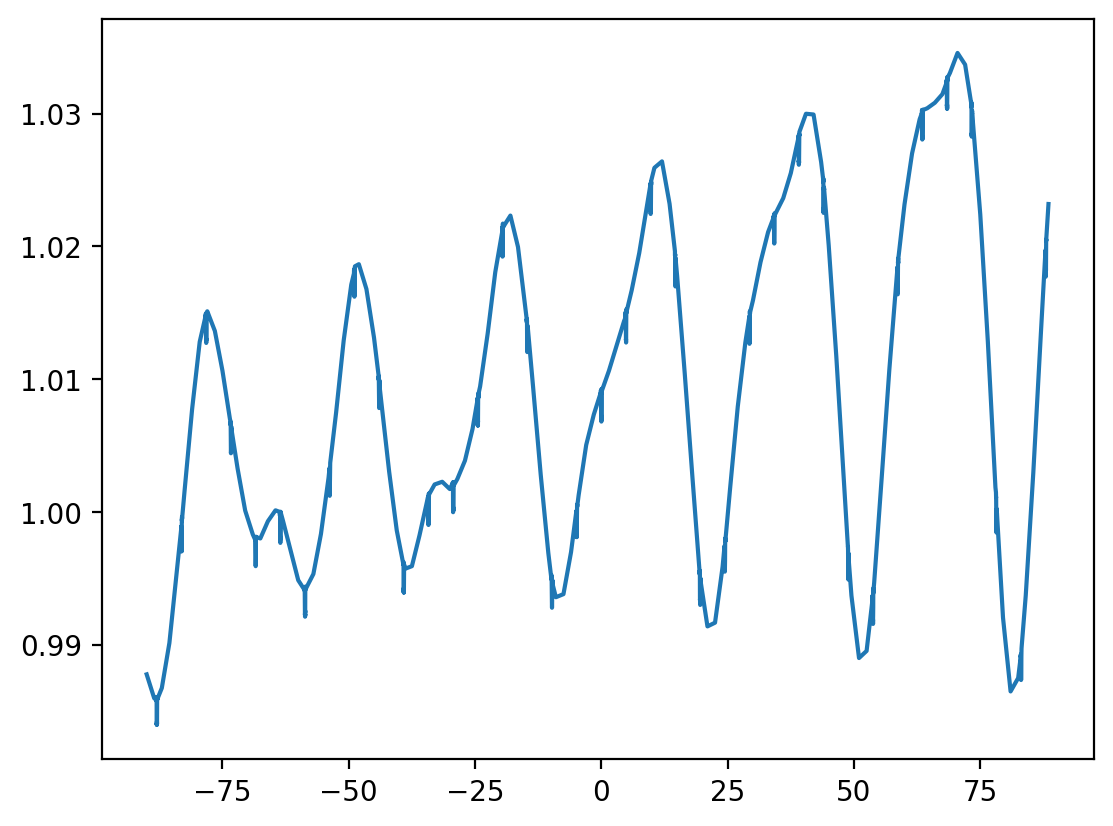

In [153]:
plt.plot(t, flux_obs)

In [154]:
len(t)

1597

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


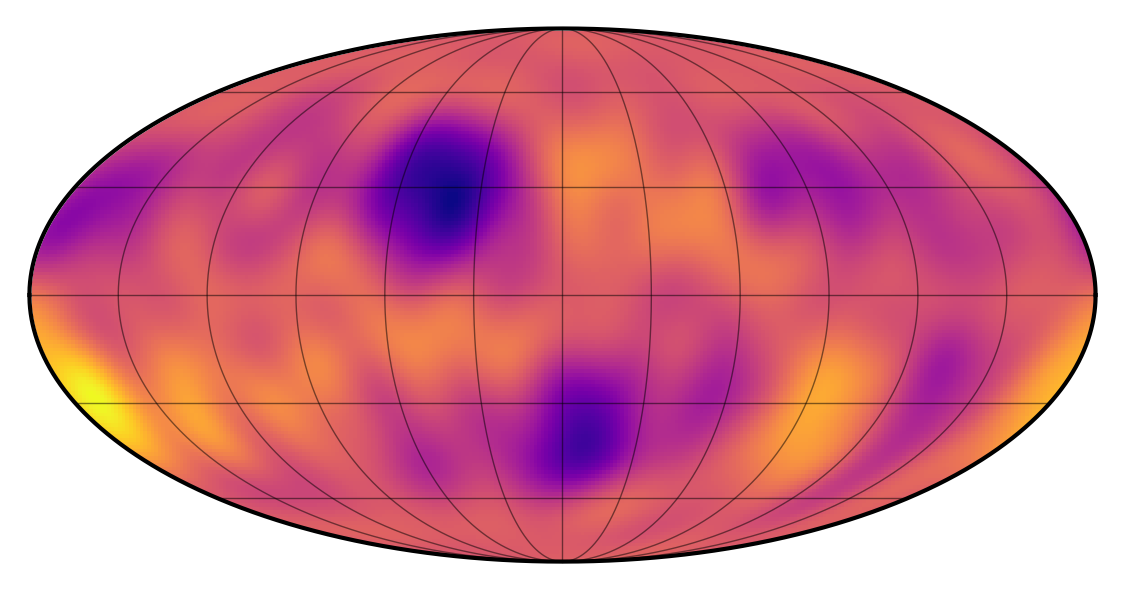

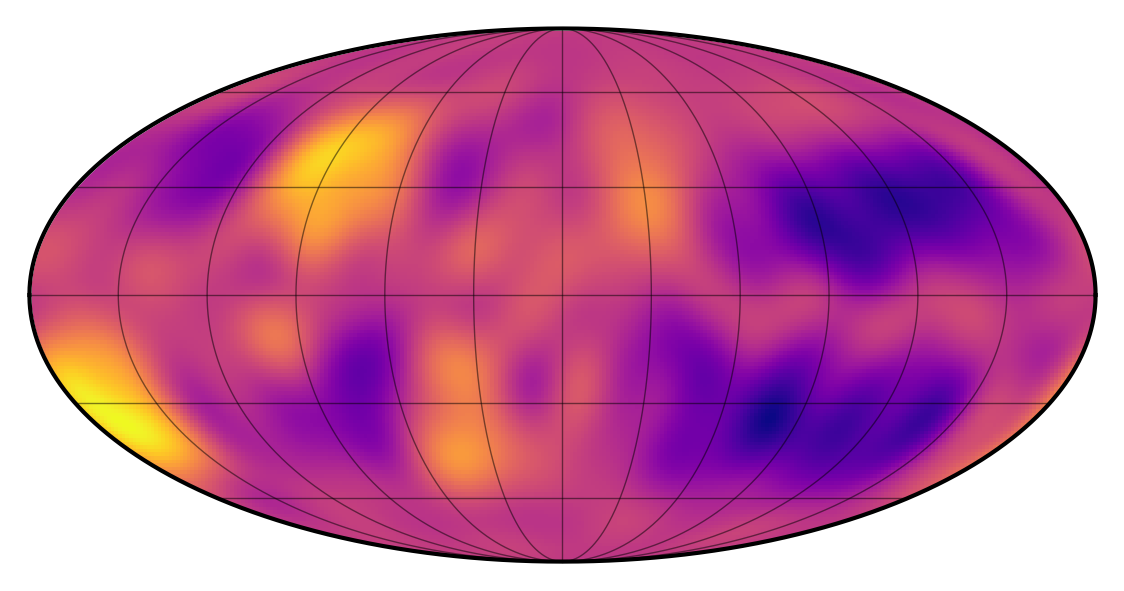

In [155]:
for y in ys_true:
    sp.visualize(y)

In [22]:
y_true = ys_true[:num_maps]

# Create new variables dynamically
variable_names = [f"y{i}_true" for i in range(num_maps)]
globals().update({variable_name: value for variable_name, value in zip(variable_names, y_true)})


/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


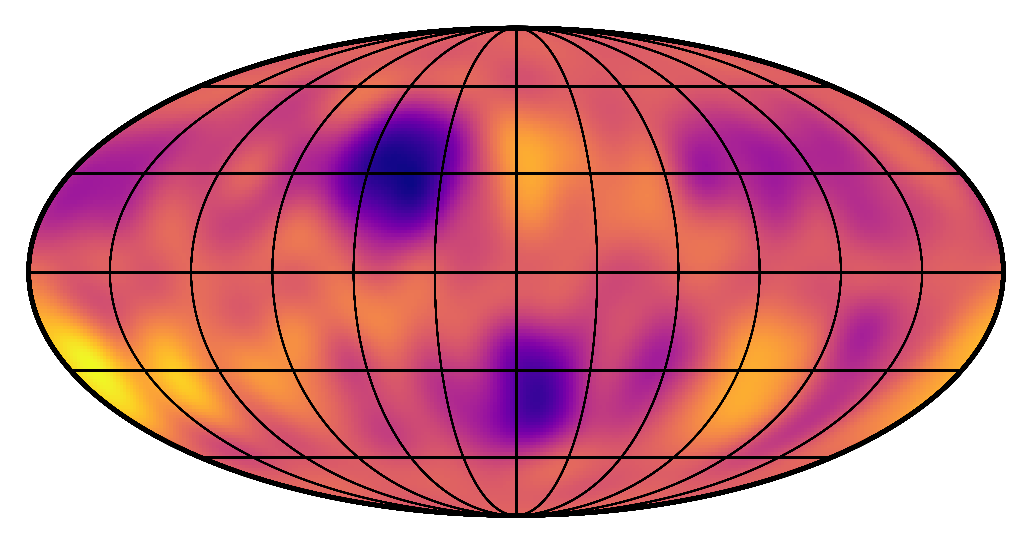

In [27]:
# Including the initial and final maps
t_interp_list = [np.linspace(t[i], t[i+1], 10) for i in range(num_maps-1)]

fig = plt.figure()
ax = plt.gca()

def frame(i):
    map_index = i // 10  # number of frames
    ti = t_interp_list[map_index][i % 10]
    t0 = t_interp_list[map_index][0]
    t1 = t_interp_list[map_index][-1]

    y_prev = globals()[f'y{map_index}_true']  # Get the y_true for the current map
    y_next = globals()[f'y{map_index+1}_true']  # Get the y_true for the next map

    y = (ti - t1) / (t0 - t1) * y_prev + (ti - t0) / (t1 - t0) * y_next

    sp.visualize(y, ax=ax)
    return fig

t_interp = np.concatenate(t_interp_list)
ani = FuncAnimation(fig, frame, frames=len(t_interp), interval=100)
ani.save("/Users/sabina/Downloads/ssp.mp4")


<ErrorbarContainer object of 3 artists>

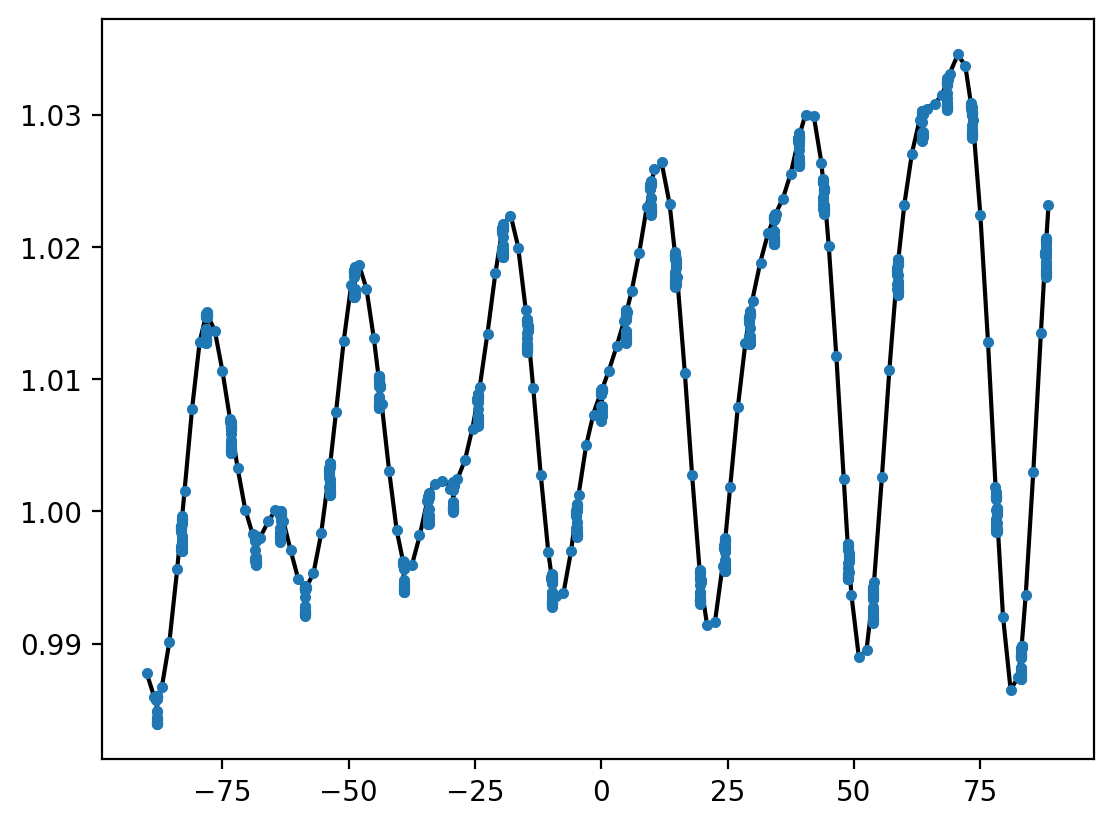

In [156]:
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')

<ErrorbarContainer object of 3 artists>

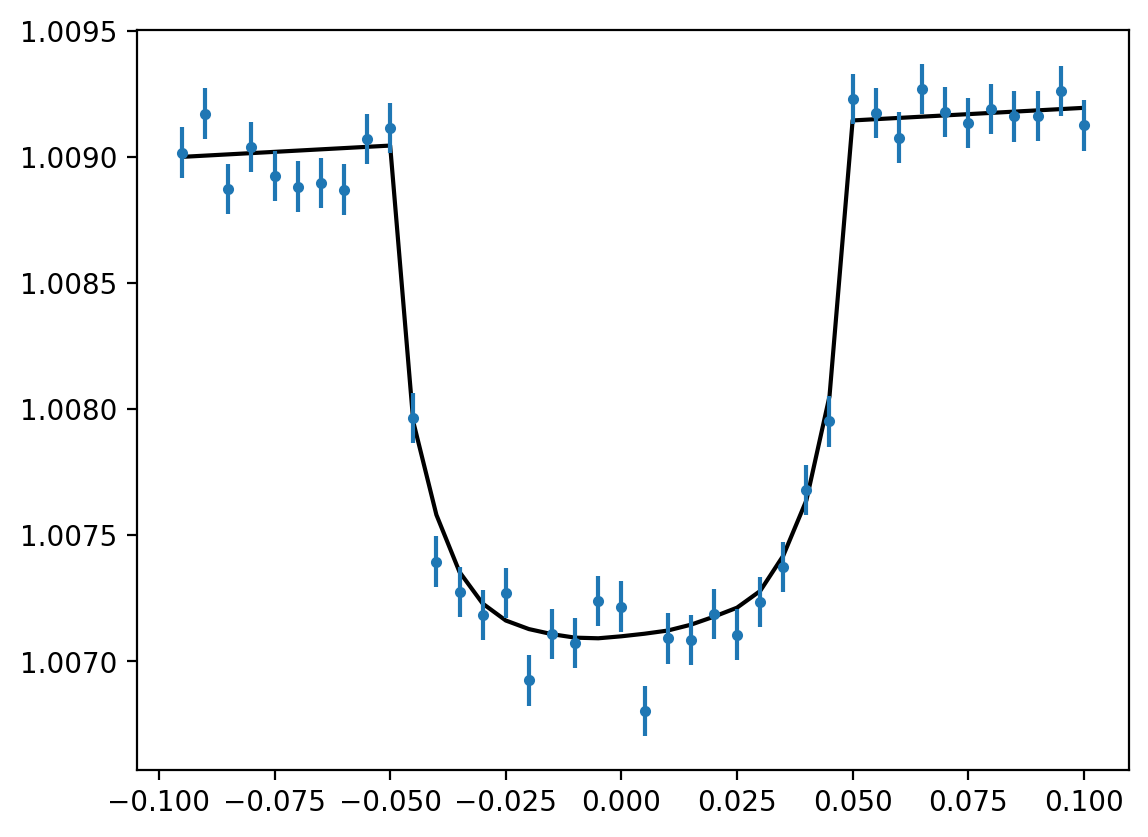

In [157]:
sel = np.abs(t) < sec.porb.eval()/10
plt.plot(t[sel], flux_true[sel], color='k')
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.')

In [158]:
flux_obs.shape

(1597,)

In [159]:
ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

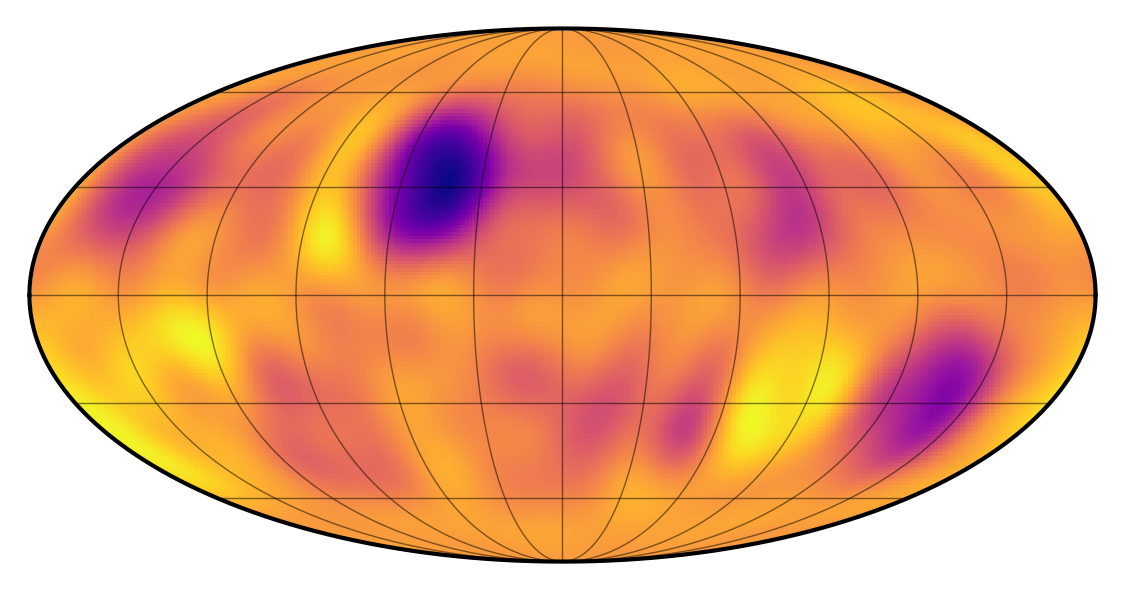

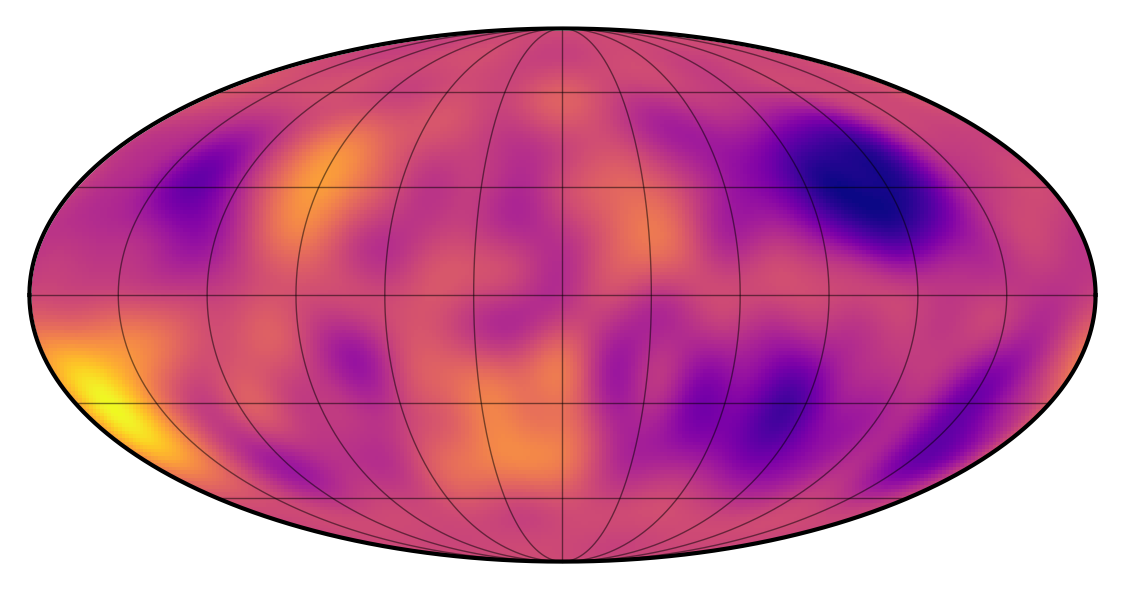

In [160]:
for i in range(num_maps):
    sp.visualize(ylm_draw[i*ssp.nlm:(i+1)*ssp.nlm])

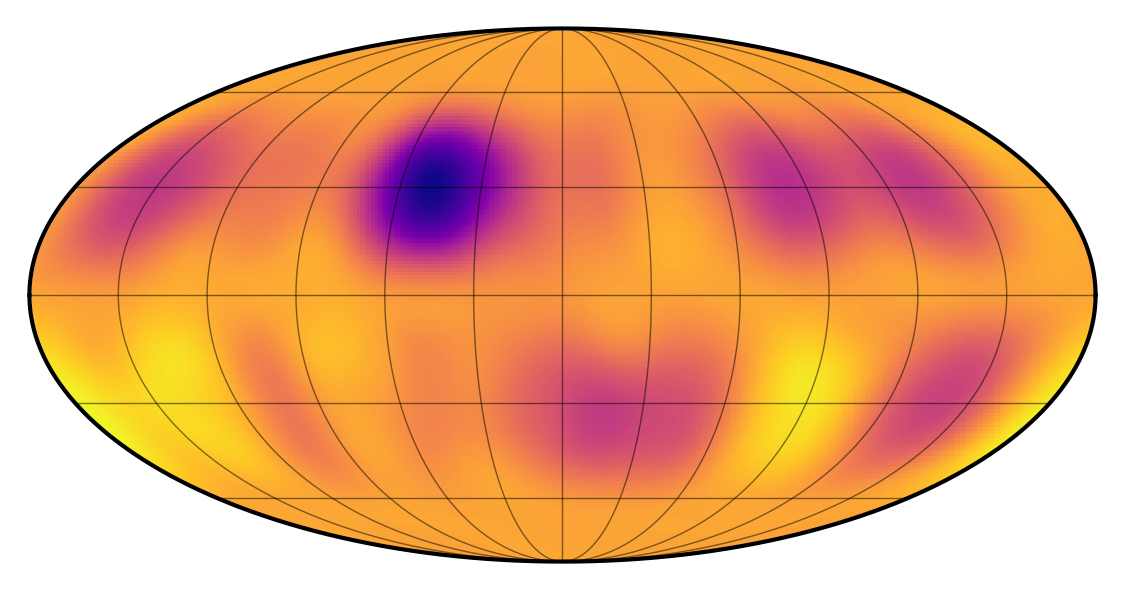

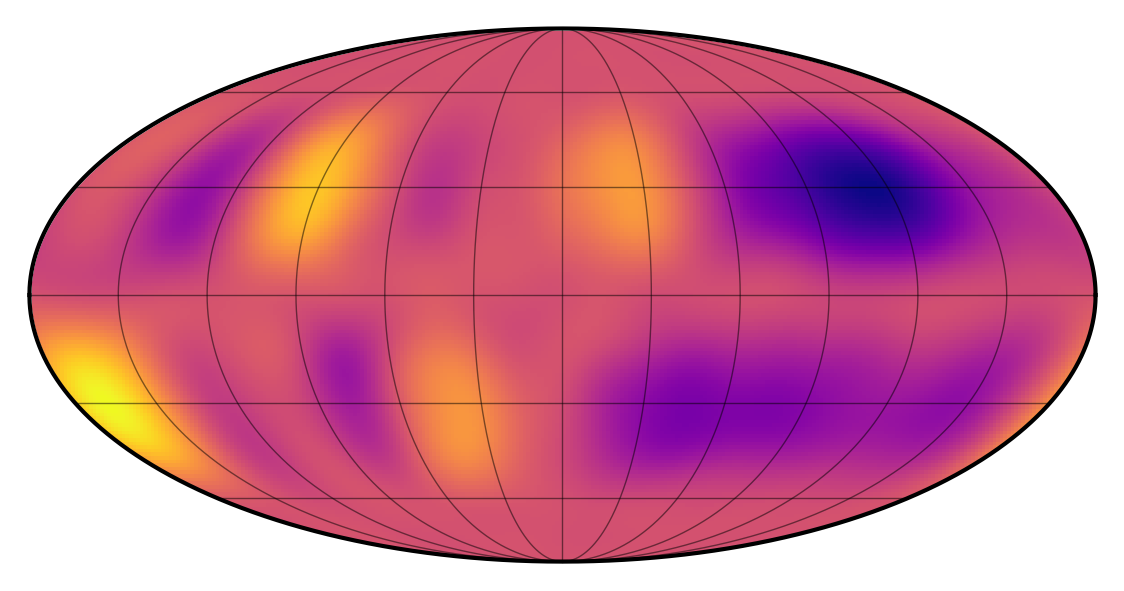

In [107]:
for i in range(num_maps):
    sp.visualize(ssp.a.eval()[i*ssp.nlm:(i+1)*ssp.nlm])

Let's double-check the Gaussian factorization; the next two cells should give identical log-likelihoods:

In [161]:
flux_obs.shape

(1597,)

In [162]:
resid = flux_obs - ssp.design_matrix.eval() @ ylm_draw

In [163]:
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid))

12498.25527069559

In [164]:
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid)) - 0.5*np.dot(ylm_draw[1:ssp.nlm] - ssp.mu.eval()[1:ssp.nlm], np.linalg.solve(ssp.Lambda.eval()[1:ssp.nlm,1:ssp.nlm], ylm_draw[1:ssp.nlm] - ssp.mu.eval()[1:ssp.nlm])) - 0.5*np.linalg.slogdet(ssp.Lambda.eval()[1:ssp.nlm,1:ssp.nlm])[1] - 0.5*(len(ylm_draw[:ssp.nlm])-1)*np.log(2*np.pi)

13963.631820232627

In [165]:
whitened_ylm_resid = np.dot(ssp.AInv_chol.T.eval()[:ssp.nlm, :ssp.nlm], ylm_draw[:ssp.nlm] - ssp.a.eval()[:ssp.nlm])
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval() - 0.5*np.dot(whitened_ylm_resid, whitened_ylm_resid) + np.sum(np.log(np.diag(ssp.AInv_chol.eval()[:ssp.nlm]))) - 0.5*len(ylm_draw[:ssp.nlm])*np.log(2*np.pi)

13904.999710775264

Let's try some fitting

In [172]:
Ttotal = t[-1] - t[0]
prot_frac_bounds = min(prot/Ttotal/2, 0.25)
porb_frac_bounds = min(porb/Ttotal/2, 0.25)

t0_bounds = 0.2 # Hard coded!

a = (pri.m.eval()*np.square(sec.porb.eval()/365.25))**(1/3) * 215.03 # Solar radii
bmax = pri.r.eval() / a

with pm.Model() as model:
    log_prot = pm.Uniform('log_prot', np.log(prot) + np.log1p(-prot_frac_bounds), np.log(prot) + np.log1p(prot_frac_bounds))
    prot = pm.Deterministic('prot', tt.exp(log_prot))

    stellar_ori_x = pm.Normal('stellar_ori_x', mu=0, sigma=1, testval=1)
    stellar_ori_y = pm.Normal('stellar_ori_y', mu=0, sigma=1, testval=1)
    stellar_ori_z = pm.Normal('stellar_ori_z', mu=0, sigma=1, testval=1)
    stellar_obl = pm.Deterministic('stellar_obl', 180.0/np.pi*tt.arctan2(stellar_ori_y, stellar_ori_x))
    stellar_inc = pm.Deterministic('stellar_inc', 180.0/np.pi*tt.arccos(stellar_ori_z / tt.sqrt(tt.square(stellar_ori_x) + tt.square(stellar_ori_y) + tt.square(stellar_ori_z))))


    pri_model = Primary(starry.Map(ydeg=ydeg, udeg=udeg, inc=stellar_inc, obl=stellar_obl), r=float(pri.r.eval()), m=float(pri.m.eval()), prot=prot, t0=0.0)
    pri_model.map[1] = u1
    pri_model.map[2] = u2

    sec_model = Secondary(starry.Map(0,0), 
                          t0=sec.t0.eval(), r=sec.r.eval(), m=float(sec.m.eval()), prot=float(sec.prot.eval()),
                          porb=porb, ecc=float(sec.ecc), Omega=0, inc=sec.inc.eval())
    
    sys_model = System(pri_model, sec_model)

    sp_model = StarryProcess(n=n, 
                             mu=tt.as_tensor_variable(mu, 'mu'),
                             sigma=tt.as_tensor_variable(sigma, 'sigma'),
                             r=tt.as_tensor_variable(r, 'r'),
                             dr=tt.as_tensor_variable(dr, 'dr'),
                             ydeg=ydeg, udeg=udeg, 
                             marginalize_over_inclination=False,)

    # Normally we would make another StarryProcess here, but because none of its parameters are being set in the model for now, we can just reuse `sp`
    ssp_model = LinearInterpolatedStarryStarryProcess(sys_model, sp_model, nt, len(pri.map.y.eval()), num_maps=num_maps)

    ssp_model._compute(t, np.zeros_like(t), np.ones_like(t))

    pm.Deterministic('flux_model', tt.dot(ssp_model.design_matrix, ssp_model.sample_ylm_conditional(t, flux_obs, sigma_flux)[0,:]))
    pm.Deterministic('y_model', ssp_model.sample_ylm_conditional(t, flux_obs, sigma_flux)[0,:])

    pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux_obs, sigma_flux))

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [173]:
with model:
    map_soln = pmx.optimize(maxeval=500)
    y_model = np.array(map_soln["flux_model"])
    flux_model = map_soln["flux_model"]

optimizing logp for variables: [stellar_ori_z, stellar_ori_y, stellar_ori_x, log_prot]


message: Desired error not necessarily achieved due to precision loss.
logp: 11065.381912744508 -> 12335.430092204817


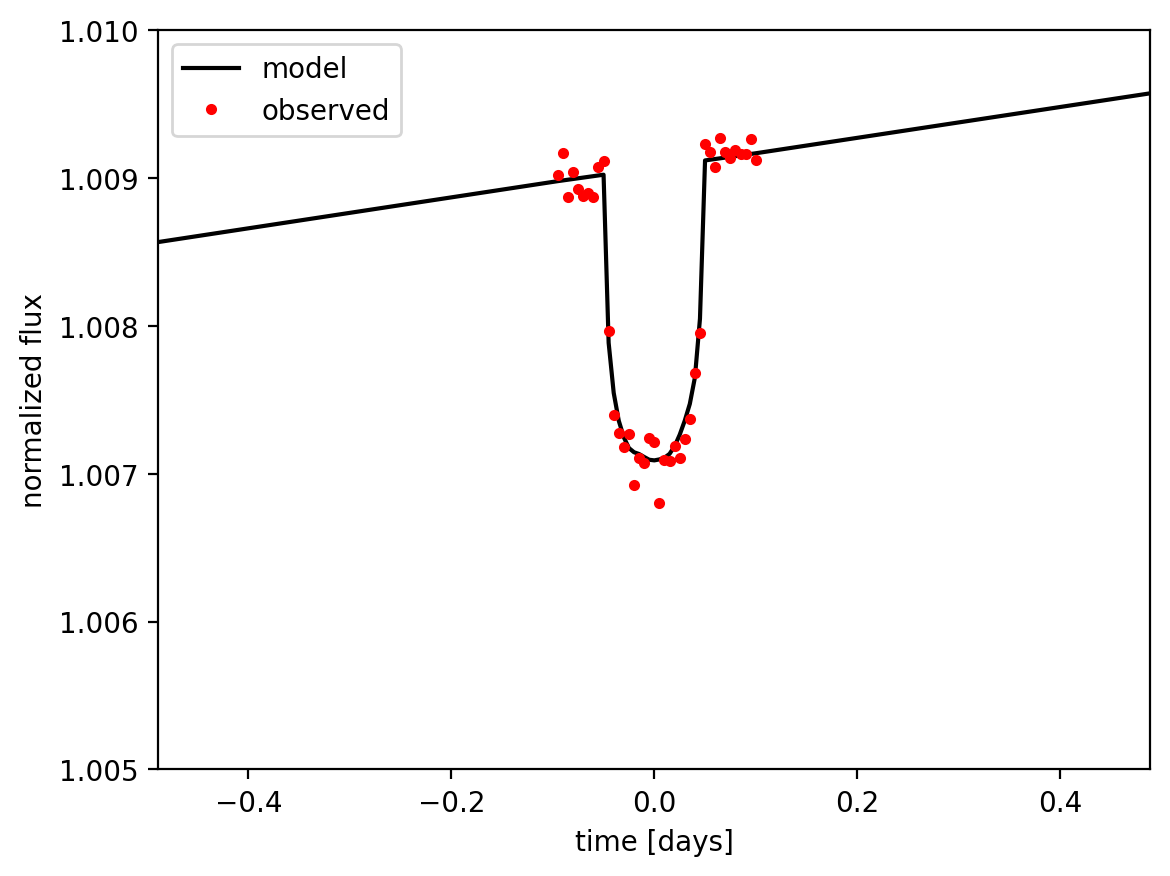

In [174]:
plt.plot(t, flux_model, 'k', label='model')
plt.plot(t, flux_obs, 'r.', label='observed')
plt.xlabel("time [days]")
plt.ylabel("normalized flux");
plt.xlim(-sec.porb.eval()/10, sec.porb.eval()/10)
plt.ylim(1.005,1.01)
plt.legend()
plt.show()

In [175]:
map_soln

{'log_prot_interval__': array(0.08324808),
 'stellar_ori_x': array(0.00903),
 'stellar_ori_y': array(-0.00556903),
 'stellar_ori_z': array(0.0002327),
 'log_prot': array(3.4011581),
 'prot': array(29.99882144),
 'stellar_obl': array(-31.66318875),
 'stellar_inc': array(88.74347641),
 'flux_model': array([0.98781681, 0.98596302, 0.98589622, ..., 1.02061031, 1.02064112,
        1.02313018]),
 'y_model': array([ 1.00150543e+00, -1.84437724e-03, -8.80808362e-03, -1.89380451e-04,
         6.35194336e-03, -1.51982698e-03, -2.90502212e-03,  8.46560923e-03,
        -2.80220406e-03, -5.92118425e-03,  1.91837549e-03, -6.91285790e-05,
         4.65666425e-04,  2.36048382e-03,  4.52980255e-03,  1.04174336e-03,
         8.62950907e-07, -4.14294238e-03,  7.54349990e-03, -2.48284876e-04,
         9.27436126e-03, -1.02229780e-03,  3.22735672e-03, -3.63918273e-03,
         1.09029943e-02,  6.92661788e-05,  2.46393972e-03, -7.37632156e-03,
        -1.18895085e-03,  4.11373345e-04,  2.50832309e-03,  8.75

In [176]:
start = dict(log_prot=np.log(30.0), stellar_ori_x=np.cos(-30*np.pi/180), stellar_ori_y=np.sin(-30*np.pi/180), stellar_ori_z=0.0)
ndraw = 1000
with model:
    trace = pm.sample(ndraw, tune=ndraw, chains=1, init='adapt_full', start=start, return_inferencedata=True)

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_43455/2218640525.py:4: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(ndraw, tune=ndraw, chains=1, init='adapt_full', start=start, return_inferencedata=True)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sequential sampling (1 chains in 1 job)
NUTS: [stellar_ori_z, stellar_ori_y, stellar_ori_x, log_prot]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 4768 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [177]:
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
stellar_ori_x   1.362  0.576   0.391    2.361      0.034    0.024     260.0   
stellar_ori_y  -0.849  0.372  -1.512   -0.254      0.022    0.016     247.0   
stellar_ori_z   0.038  0.054  -0.055    0.154      0.002    0.002     560.0   
log_prot        3.401  0.000   3.401    3.401      0.000    0.000     351.0   
prot           29.999  0.003  29.994   30.004      0.000    0.000     351.0   
...               ...    ...     ...      ...        ...      ...       ...   
y_model[507]    0.000  0.001  -0.001    0.001      0.000    0.000    1026.0   
y_model[508]   -0.000  0.000  -0.001    0.001      0.000    0.000     971.0   
y_model[509]   -0.000  0.000  -0.001    0.001      0.000    0.000    1072.0   
y_model[510]    0.000  0.000  -0.001    0.001      0.000    0.000     944.0   
y_model[511]   -0.000  0.000  -0.001    0.001      0.000    0.000     963.0   

               ess_tail  r_hat  
stellar_ori_x     229.0    NaN  
stellar_ori_y     262.0    NaN  
stellar_ori_z     480.0    NaN  
log_prot          381.0    NaN  
prot              381.0    NaN  
...                 ...    ...  
y_model[507]      860.0    NaN  
y_model[508]      914.0    NaN  
y_model[509]      779.0    NaN  
y_model[510]      942.0    NaN  
y_model[511]      827.0    NaN  

[2116 rows x 9 columns]

array([[<Axes: title={'center': 'prot'}>,
        <Axes: title={'center': 'prot'}>],
       [<Axes: title={'center': 'stellar_inc'}>,
        <Axes: title={'center': 'stellar_inc'}>],
       [<Axes: title={'center': 'stellar_obl'}>,
        <Axes: title={'center': 'stellar_obl'}>]], dtype=object)

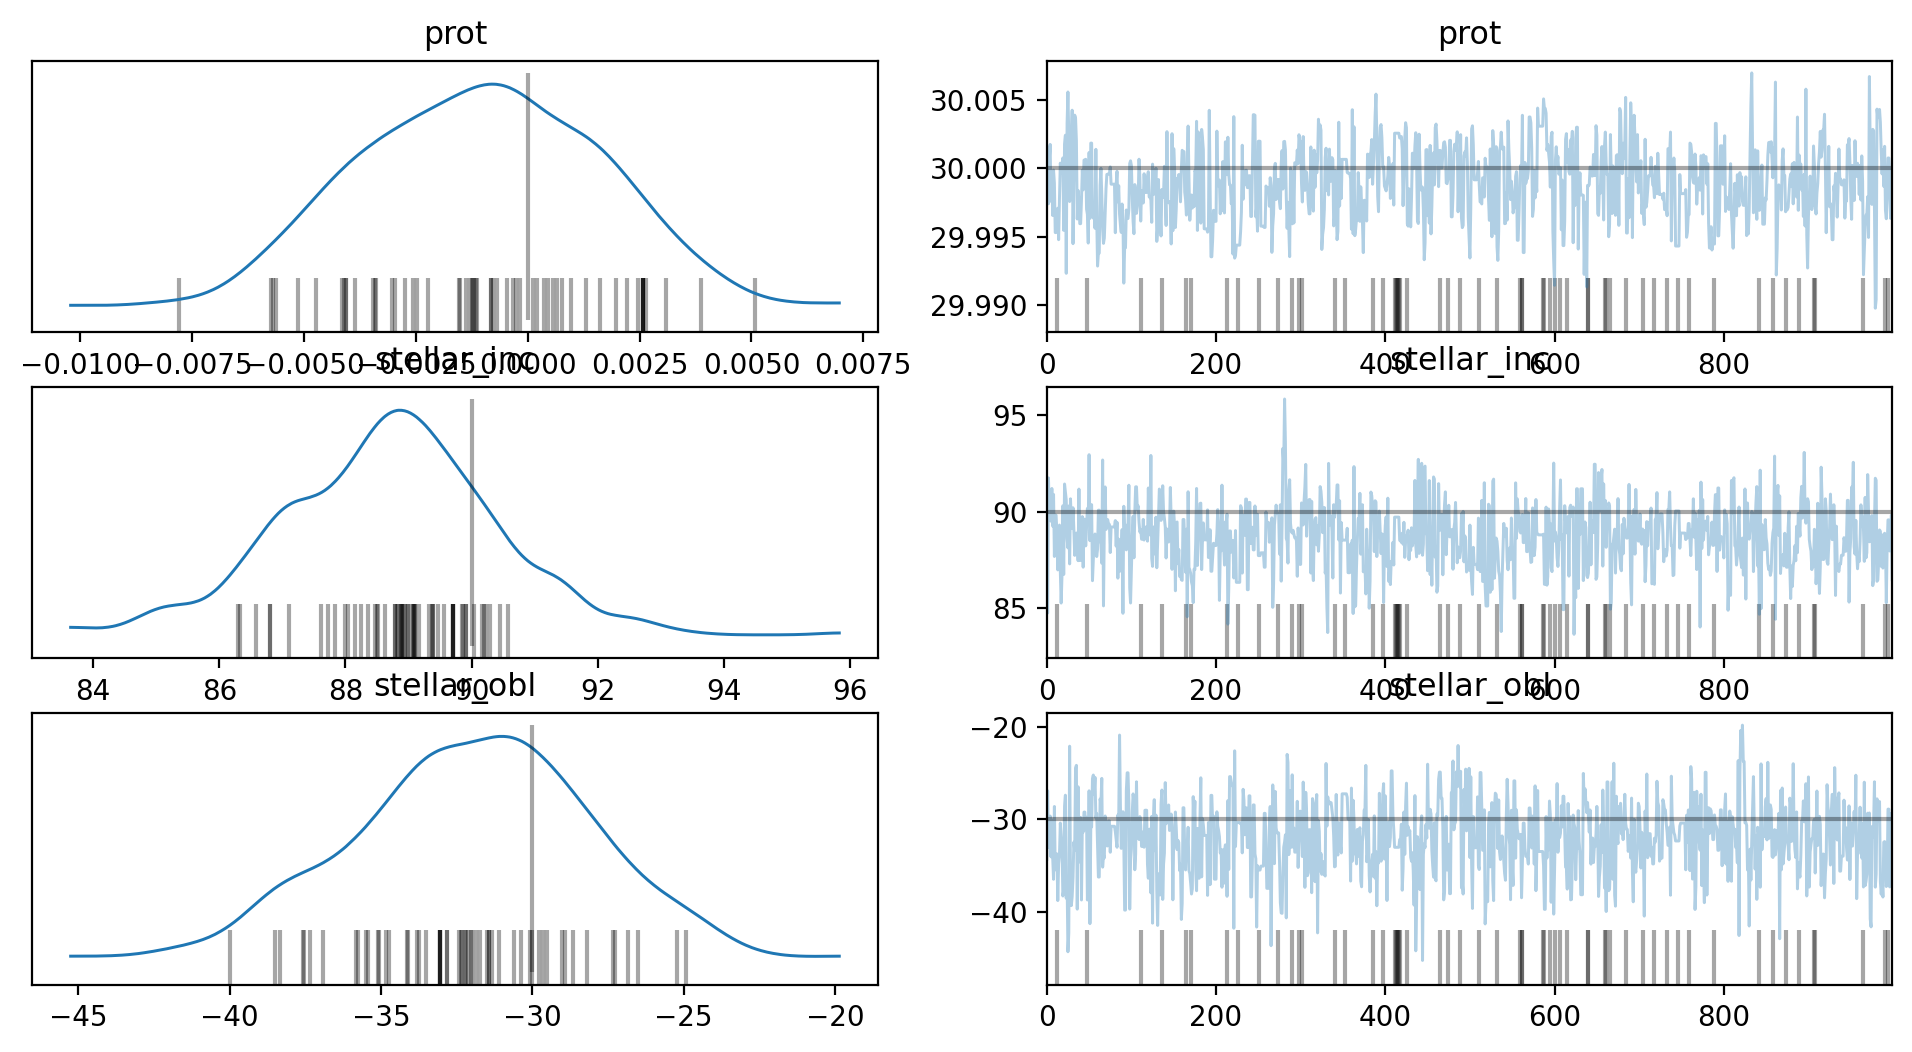

In [178]:
az.plot_trace(trace, var_names=['prot', 'stellar_inc', 'stellar_obl'],
              lines=[('prot', {}, pri.prot.eval()), 
                     ('stellar_inc', {}, 90),
                     ('stellar_obl', {}, -30),
                     ])

In [179]:
p = trace.posterior.sel(chain=0, draw=0)

array([[<Axes: ylabel='prot'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='stellar_inc'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='prot', ylabel='stellar_obl'>,
        <Axes: xlabel='stellar_inc'>, <Axes: xlabel='stellar_obl'>]],
      dtype=object)

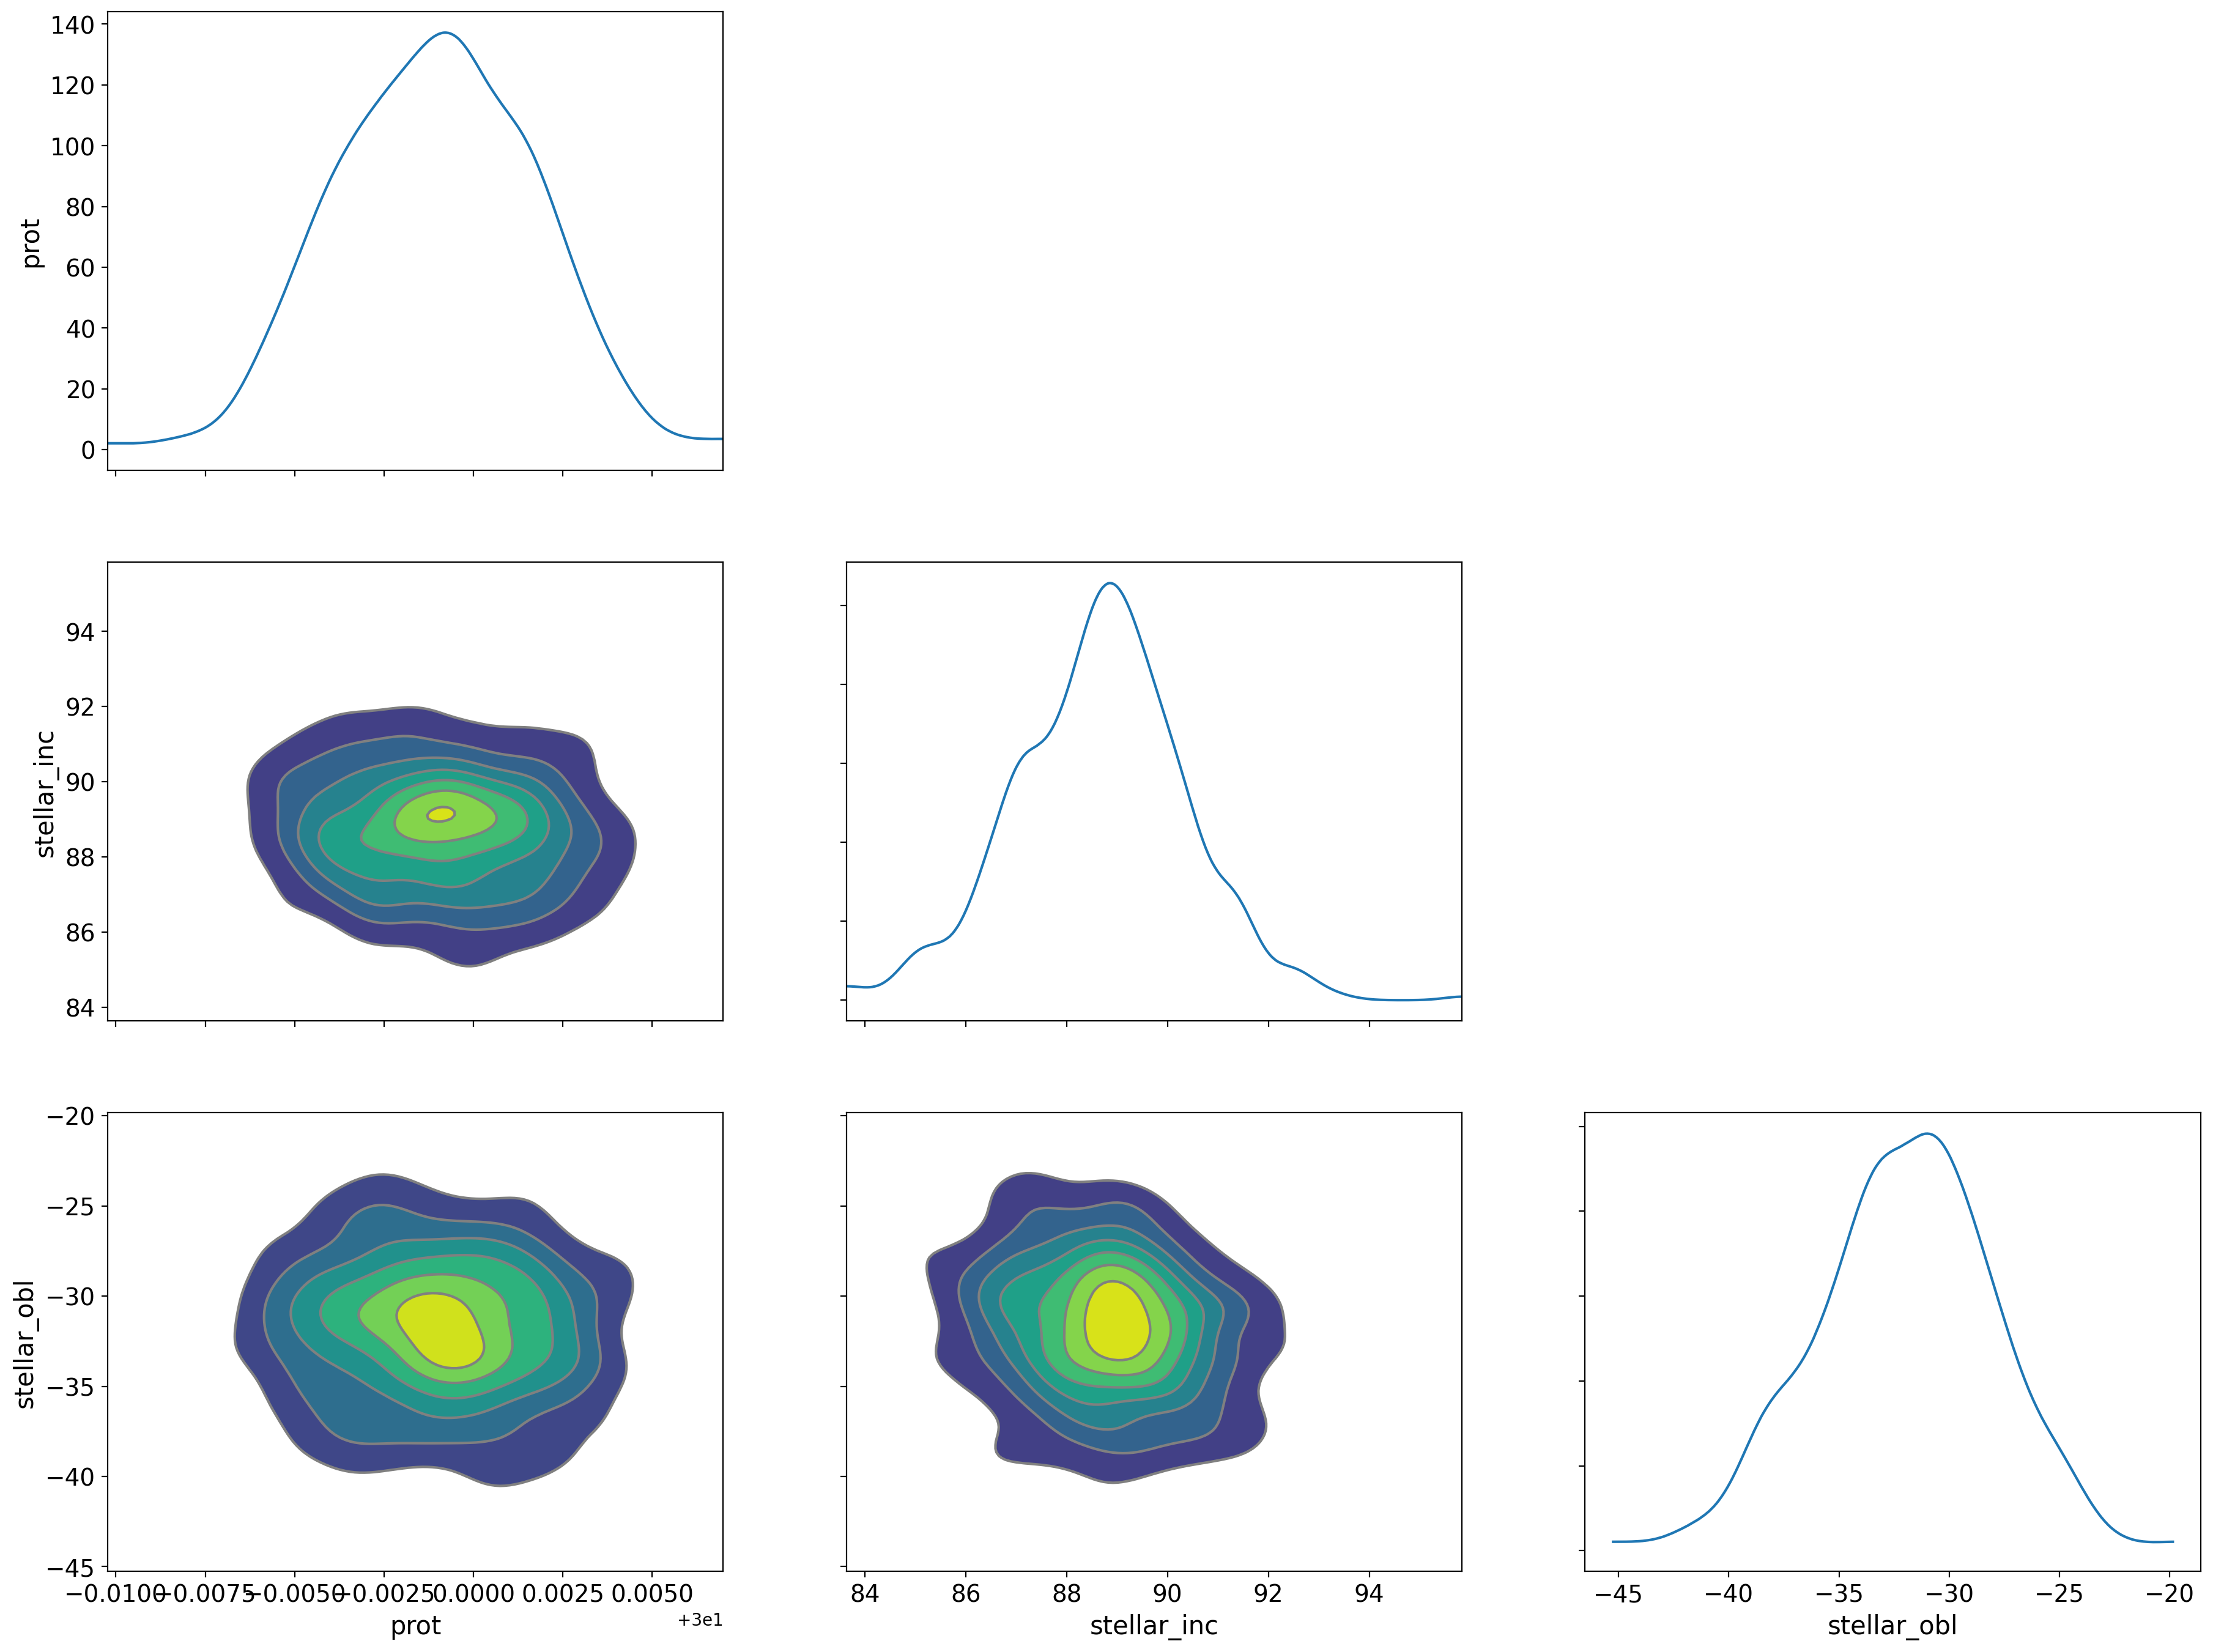

In [180]:
az.plot_pair(trace, var_names=['prot', 'stellar_inc', 'stellar_obl'], kind='kde', marginals=True)

In [182]:
map_ylms = []
f = theano.function([model.prot, model.stellar_inc, model.stellar_obl], ssp_model.sample_ylm_conditional(t, flux_obs, sigma_flux))
# f = theano.function([model.prot], ssp_model.sample_ylm_conditional(t, flux_obs, sigma_flux))

for c in trace.posterior.coords['chain']:
    for d in tqdm(trace.posterior.coords['draw']):
        p = trace.posterior.sel(chain=c, draw=d)
        map_ylms.append(f(p.prot, p.stellar_inc, p.stellar_obl))
        # map_ylms.append(f(p.prot))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [183]:
map_ylms = np.array(map_ylms)
map_ylms = np.reshape(map_ylms, (1, -1, num_maps*ssp.nlm))

In [184]:
map_ylms.shape

(1, 1000, 512)

And here is the posterior mean surface map:

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


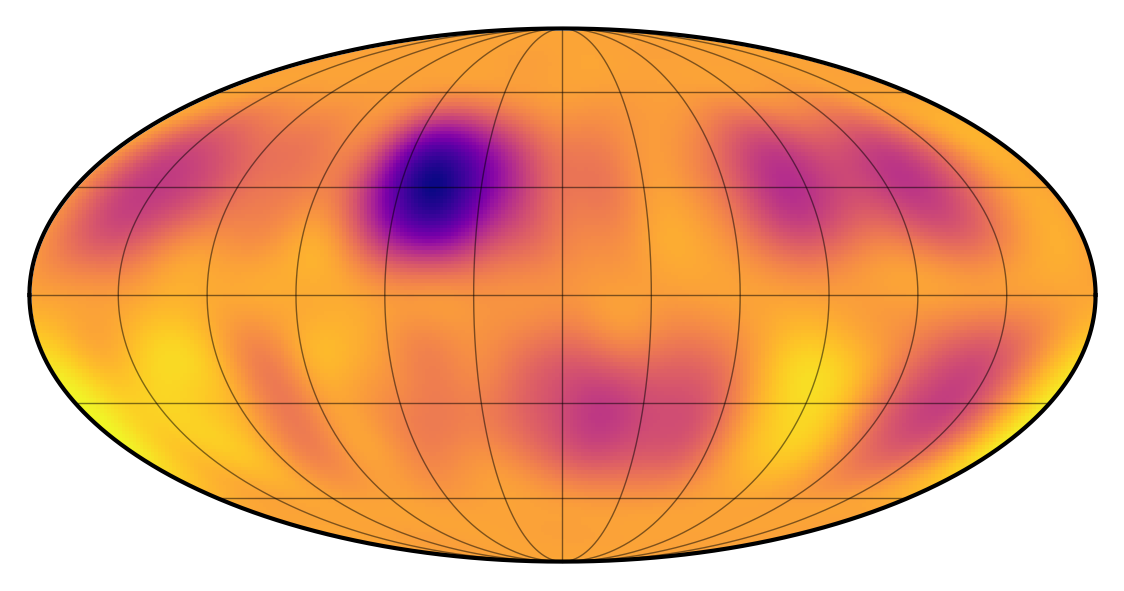

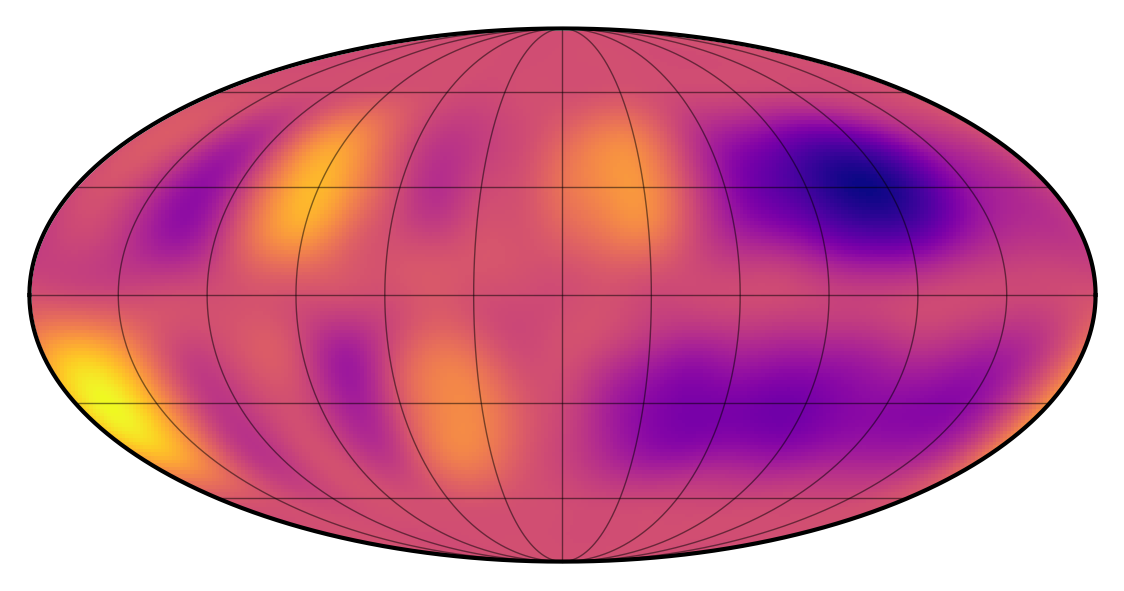

In [185]:
for i in range(num_maps):
    sp_model.visualize(np.mean(map_ylms[:,:,i*ssp.nlm:(i+1)*ssp.nlm], axis=(0,1)))

Save the trace:

In [186]:
az.to_netcdf(trace, 'LinearSSP-trace-nmaps.nc')

'LinearSSP-trace-nmaps.nc'

In [187]:
p.y_model.shape

(512,)

Pre-computing some matrices... Done.
Compiling `render`... Done.


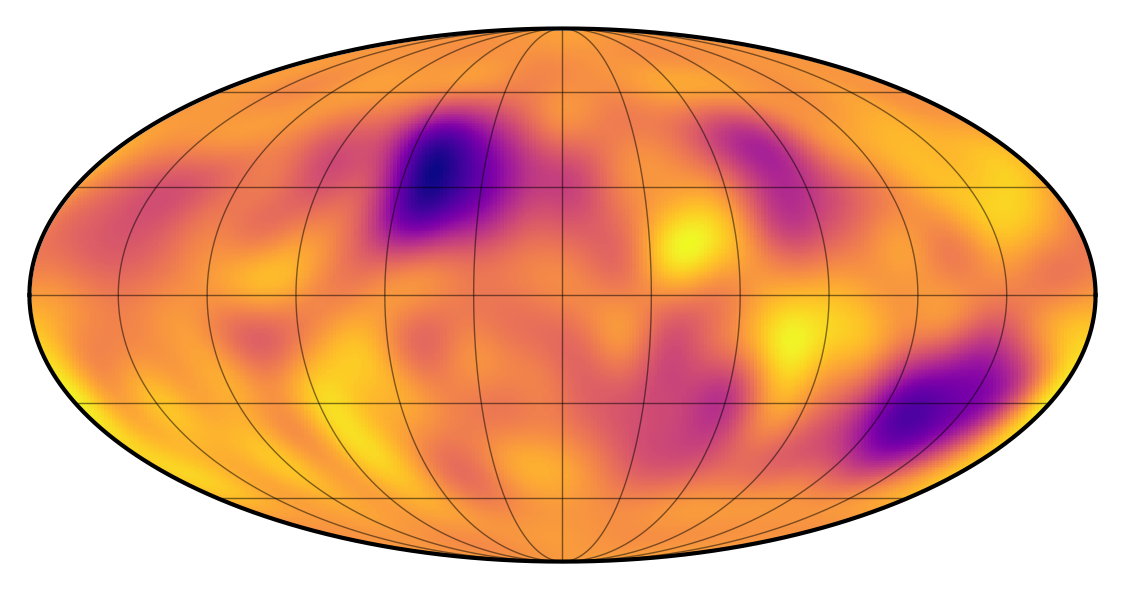

In [188]:
map_inf = starry.Map(ydeg=15, udeg=2)
map_inf[:,:] = p.y_model[:nlm]
map_inf.show(projection="moll")

Pre-computing some matrices... Done.
Compiling `render`... Done.


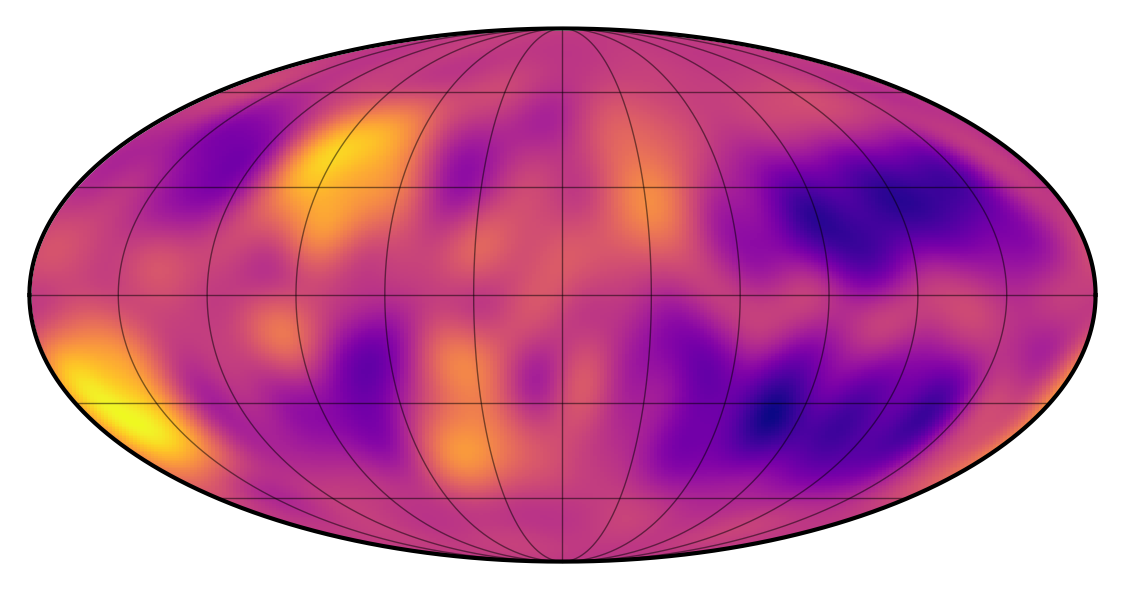

In [190]:
map = starry.Map(ydeg, udeg=udeg, inc=90, obl=-30)
map[:,:] = ys_true[1]
map.show(projection="moll")

Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.


(1.006, 1.01)

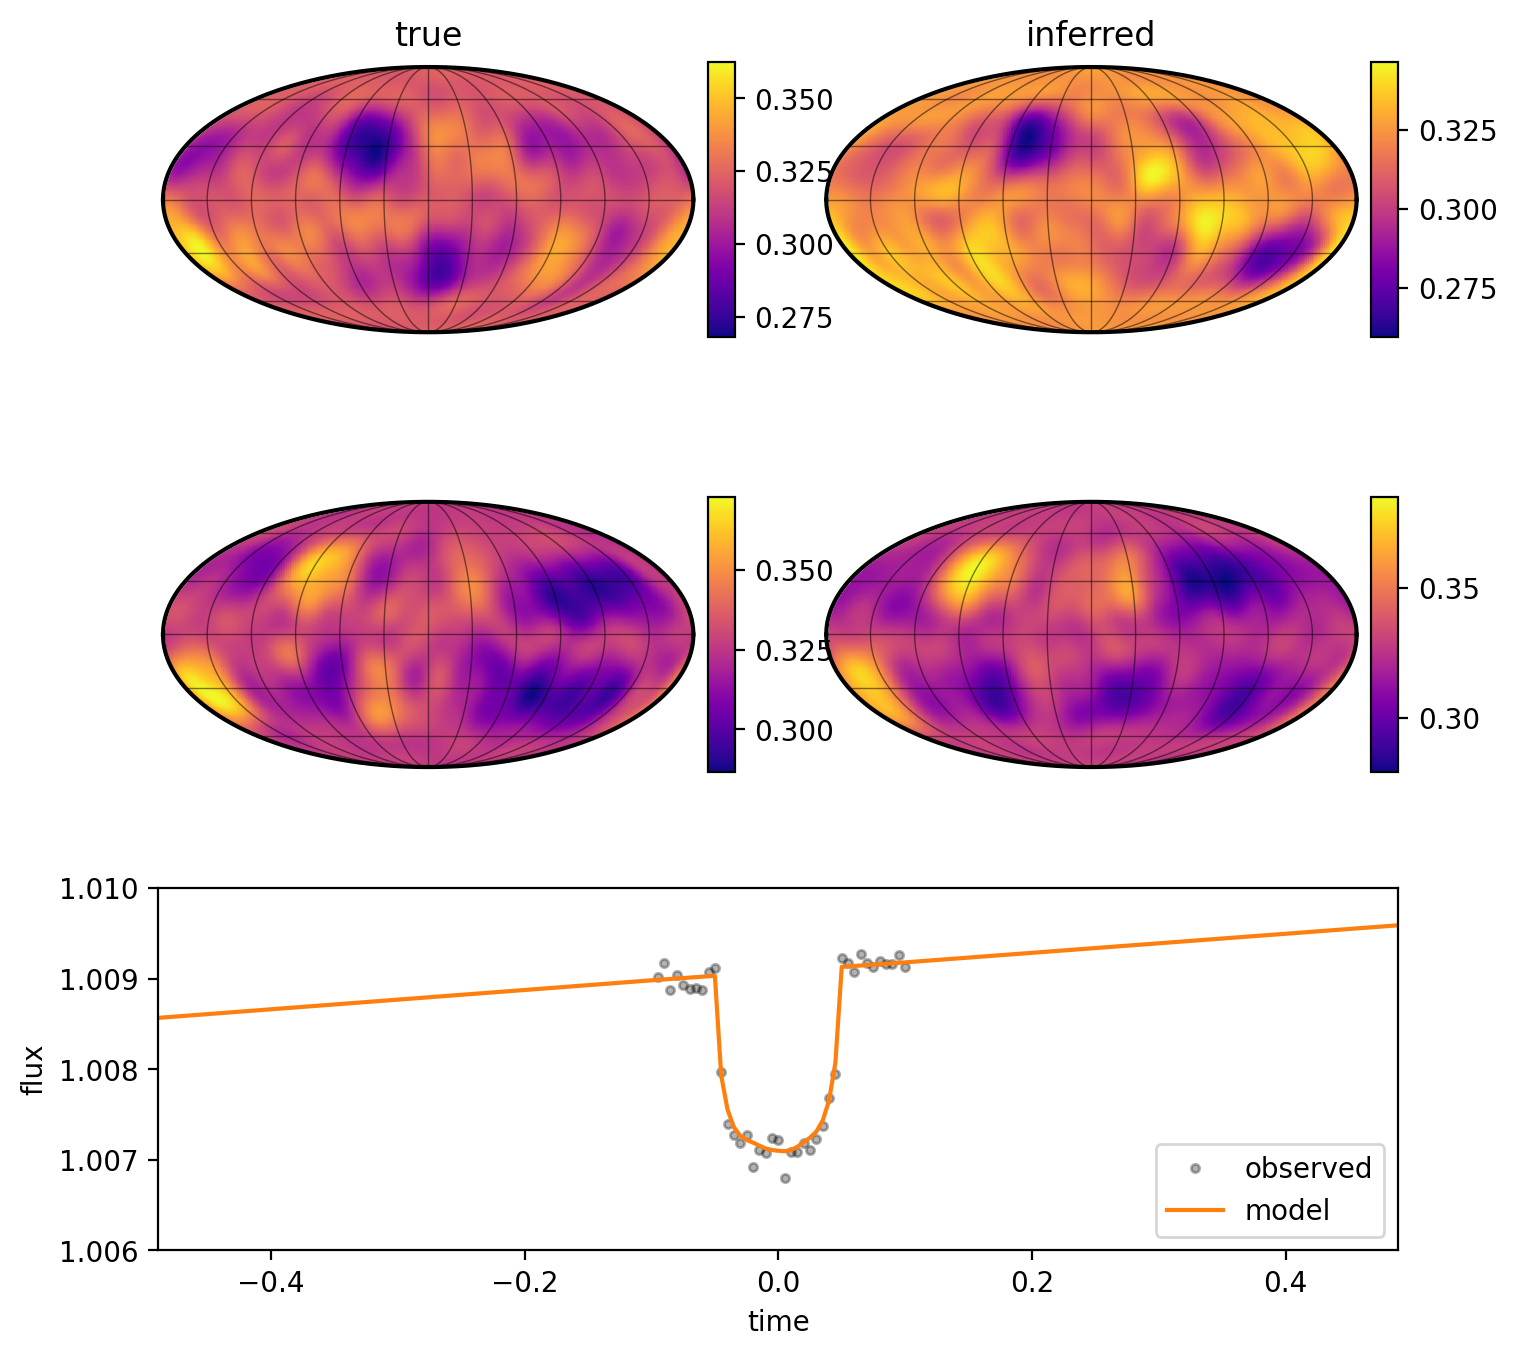

In [191]:
from matplotlib import colors
cmap = plt.get_cmap("plasma")
cmap.set_under("#666666")
cmap.set_over("w")
cnorm = lambda: colors.Normalize(vmin=0.0)
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.15)
ax = [
    plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (1, 0), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1),
]

# Show the true map
map = starry.Map(ydeg, udeg=udeg, inc=90, obl=-30)
map[:,:] = ys_true[0]
map.show(
    ax=ax[0],
    projection="moll",
    colorbar=True,
)
ax[0].set_title('true')

map = starry.Map(ydeg, udeg=udeg, inc=90, obl=-30)
map[:,:] = ys_true[1]
map.show(
    ax=ax[2],
    projection="moll",
    colorbar=True,
)

# Show the inferred map
map_inf = starry.Map(ydeg=15, udeg=2)
map_inf[:,:] = p.y_model[:nlm]
map_inf.show(
    ax=ax[1],
    projection="moll",
    colorbar=True,
)
ax[1].set_title('inferred')

map_inf = starry.Map(ydeg=15, udeg=2)
map_inf[:,:] = p.y_model[nlm:2*nlm]
map_inf.show(
    ax=ax[3],
    projection="moll",
    colorbar=True,
)

# Show the flux model
ax[4].plot(t, flux_obs, "k.", alpha=0.3, label="observed")
ax[4].plot(t, p.flux_model, "C1", label="model")
ax[4].legend(fontsize=10, loc="lower right")
ax[4].set_xlabel("time")
ax[4].set_ylabel("flux")
ax[4].set_xlim(-sec.porb.eval()/10, sec.porb.eval()/10)
ax[4].set_ylim(1.006, 1.01)

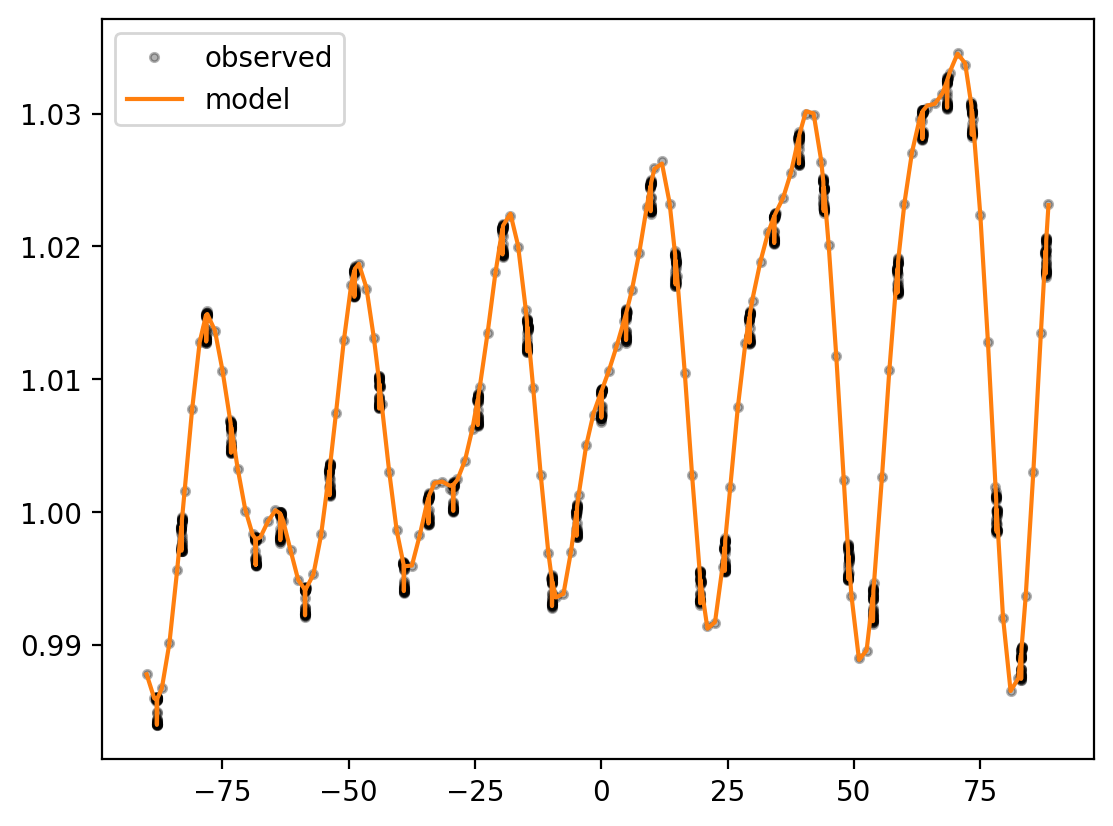

In [193]:
plt.plot(t, flux_obs, "k.", alpha=0.3, label="observed")
plt.plot(t, p.flux_model, "C1", label="model")
plt.legend()